[Prophet Toolbox Documentation](https://facebook.github.io/prophet/docs/saturating_forecasts.html)

# Import

## Path

In [1]:
import os
import sys

p = os.path.abspath('../')
if p not in sys.path:
    print('Adding {} path to system'.format(p))
    sys.path.append(p)
    


Adding C:\Cerebral\_MarioSandBox\Python\covid path to system


The [Epidemiological Data from the COVID-19 Outbreak in Canada](https://github.com/ishaberry/Covid19Canada) located in github.



In [2]:
import plotly# Complete Database
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Modules

In [3]:
from myFunctions.covid import covid as cvd
import myFunctions.myVis as myVis
import myFunctions.mySIGR as mySIGRModel

In [4]:
import pandas as pd
import numpy as np

In [5]:
from utilities.EpiModel import *
import utilities.PDEparams as pde
from scipy.integrate import odeint

In [6]:
from scipy.integrate import solve_ivp
import optuna
optuna.logging.disable_default_handler()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import timedelta

# Modeling Functions

In [7]:
def getPop(province='Ontario',p='C:\Cerebral\_MarioSandBox\Python\covid'):
    provinceDataPopFile = '\data\provincePop.csv'
    popData = pd.read_csv(p + provinceDataPopFile)
    popData = popData.set_index('province')    
    return popData.loc[province].population

In [8]:
def sigr(X,t,bi,bg,p,g):
    S,I,IG,R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dR]

def sigrm(X,t,bi,bg,p,g,m):
    S,I,IG,R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG-m*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dR]

def sol_sigr(init,t,bi,bg,p,g):
    sol=odeint(sigr,init,t,args=(bi,bg,p,g))
    return(sol)

def sol_sigrm(init,t,bi,bg,p,g,m):
    sol=odeint(sigr,init,t,args=(bi,bg,p,g,m))
    return(sol)

In [9]:
def init_s():
    return 1-init_i()

def init_sd():
    return 0

def init_e():
    return 0
    
def init_a():
    return 0

def init_id():
    return 0

def init_i():
    return df['I'][0]

def init_r():
    return 0

# Get Data

In [10]:
covidObject = cvd(cached=True)

Getting COVID data
cached


In [11]:
provToAnalyze = 'Ontario'
covidObject.getProcessedData(provToAnalyze)

In [12]:
# convert dictionary into dataframe
dfData = pd.DataFrame.from_dict(covidObject.dataProcess)
# convert date col to datetime pandas series
dfData['date'] = pd.to_datetime(dfData['date'])
# convert index to dates
dfData = dfData.set_index('date')

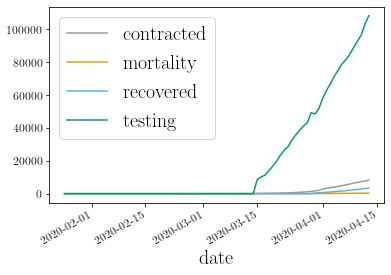

In [13]:
dfData.plot()

In [14]:
dfData.tail()

,contracted,mortality,recovered,testing
date,,,,
2020-04-09,6397,233,2305,88698
2020-04-10,6804,269,2574,92673
2020-04-11,7294,290,2858,96321
2020-04-12,7727,303,3121,103165
2020-04-13,8221,333,3357,108230


In [15]:
provPop = getPop('Ontario')

# Trend Analysis

### Contracted

From the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-05 (25)    | 2020-03-20 (40)  |
| 2     | 2020-03-20 (40)    | 2020-04-04 (55)  |
| 3     | 2020-04-04 (55)    | today (:)        |

In [16]:
phase = [1,2,3]
phaseStart = [25,40,55]
phaseEnd = [40,55,len(dfData)]

critPhaseCases = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseCases.append(dictPhase)

### Deaths

Similar to the number of cases graph from the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-18 (38)    | 2020-03-28 (48)  |
| 2     | 2020-03-28 (48)    | 2020-04-06 (57)  |
| 3     | 2020-04-06 (57)    | today (:)        |

In [17]:
phaseStart = [38,48,57]
phaseEnd = [48,57,len(dfData)]

critPhaseDeath = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseDeath.append(dictPhase)

# Modeling SIRM

In [18]:
critPhaseCases

[{'phase': 1, 'phaseStart': 25, 'phaseEnd': 40},
 {'phase': 2, 'phaseStart': 40, 'phaseEnd': 55},
 {'phase': 3, 'phaseStart': 55, 'phaseEnd': 65}]

In [19]:
dfData.tail()

,contracted,mortality,recovered,testing
date,,,,
2020-04-09,6397,233,2305,88698
2020-04-10,6804,269,2574,92673
2020-04-11,7294,290,2858,96321
2020-04-12,7727,303,3121,103165
2020-04-13,8221,333,3357,108230


## Estimation

Now analyzing phase 1
       $bi$      $bg$       $p$       $g$
0  0.373809  0.504534  0.129814  0.199471
error is 6.174597556469384e-13
Now analyzing phase 2
       $bi$      $bg$       $p$       $g$
0  0.328191  0.459411  0.189706  0.155175
error is 4.8311671127433714e-11
Now analyzing phase 3
       $bi$      $bg$       $p$       $g$
0  0.300015  0.300289  0.120056  0.199985
error is 4.101474607289073e-10


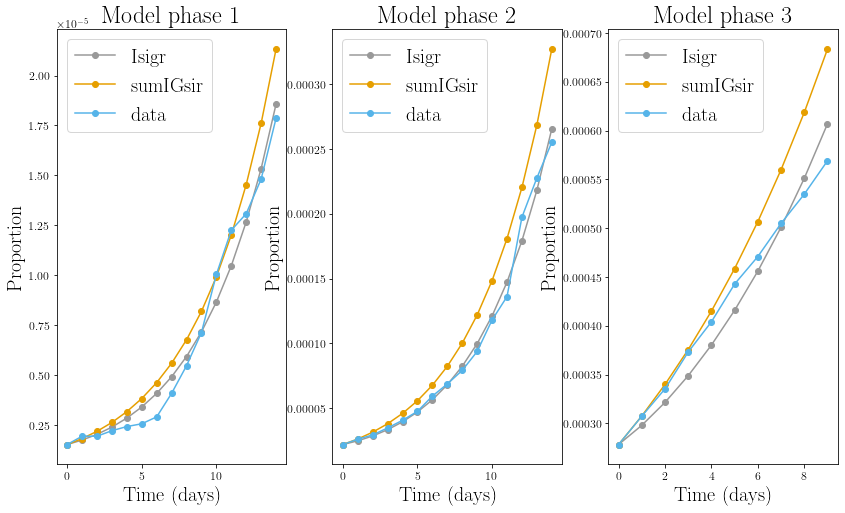

In [23]:
figNum = 1
fig1,ax=plt.subplots(1,3,figsize=(14,8))
for phase in critPhaseCases:
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    my_sigr=pde.PDEmodel(df,
                         sigr,
                         [init_s,init_i,init_id,init_r],
                         bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5)],
                         param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$'], 
                         nvars=4, 
                         ndims=0, 
                         nreplicates=1, 
                         obsidx=[1], 
                         outfunc=None)
    
    my_sigr.fit()
    
    my_sigr.best_params
    print(f"error is {my_sigr.best_error}")

    bestPars_sigr=my_sigr.best_params
    biBsigr=bestPars_sigr['$bi$'][0]
    bgBsigr=bestPars_sigr['$bg$'][0]
    pBsigr=bestPars_sigr['$p$'][0]
    gBsigr=bestPars_sigr['$g$'][0]


    bestSol_sigr=odeint(sigr,[init_s(),init_i(),init_id(),init_r()],range(len(iData)),args=(biBsigr,bgBsigr,pBsigr,gBsigr))
    Ssigr=bestSol_sigr.T[0]
    Isigr=bestSol_sigr.T[1]
    IGsigr=bestSol_sigr.T[2]
    Rsigr=bestSol_sigr.T[3]
    
    
    ax[phase['phase']-1].plot(range(len(iData)),Isigr,'-o',label='Isigr')
    #ax[phase['phase']-1].plot(range(len(iData)),IGsigr,'-o',label='IGsigr')
    ax[phase['phase']-1].plot(range(len(iData)),Isigr + IGsigr,'-o',label='sumIGsir')
    ax[phase['phase']-1].plot(range(len(iData)),df['I'],'-o',label='data')
    ax[phase['phase']-1].set_title(f"Model phase {phase['phase']}")
    ax[phase['phase']-1].set_xlabel('Time (days)')
    ax[phase['phase']-1].set_ylabel('Proportion')
    ax[phase['phase']-1].legend()

The ISIGR portion looks good but it is projected to over estimate

Now analyzing phase 1
       $bi$      $bg$       $p$       $g$       $m$
0  0.433969  0.472507  0.332167  0.194667  0.243981
error is 5.97565854617504e-13
Now analyzing phase 2
       $bi$      $bg$       $p$       $g$       $m$
0  0.320188  0.490433  0.184973  0.150723  0.013696
error is 4.831858572316865e-11
Now analyzing phase 3
       $bi$      $bg$       $p$       $g$      $m$
0  0.300415  0.300216  0.100024  0.198702  0.24987
error is 2.4106230055390444e-10


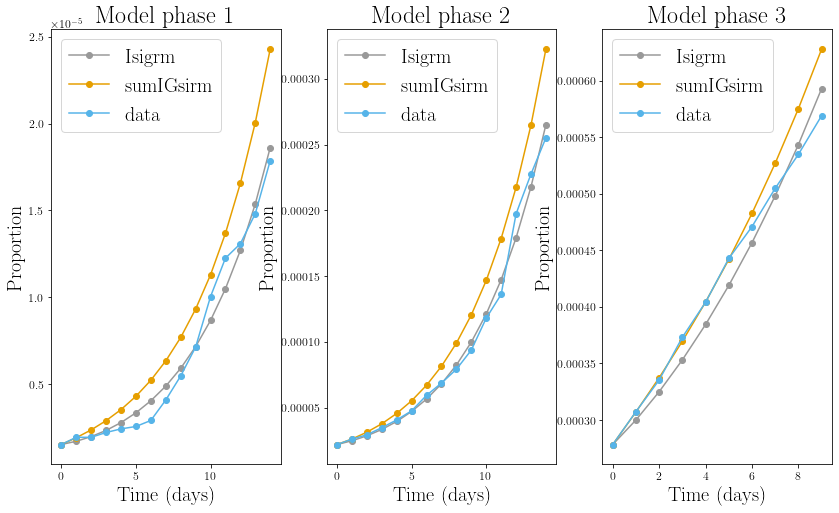

In [25]:
figNum = 1
fig1,ax=plt.subplots(1,3,figsize=(14,8))
for phase in critPhaseCases:
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    #Parameter estimation
    my_sigrm=pde.PDEmodel(df,sigrm,[init_s,init_i,init_id,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(1/100,1/4)],
                   param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)
    my_sigrm.fit()
    
    my_sigrm.best_params
    print(f"error is {my_sigrm.best_error}")
    
    bestPars_sigrm=my_sigrm.best_params
    biBsigrm=bestPars_sigrm['$bi$'][0]
    bgBsigrm=bestPars_sigrm['$bg$'][0]
    pBsigrm=bestPars_sigrm['$p$'][0]
    gBsigrm=bestPars_sigrm['$g$'][0]
    mBsigrm=bestPars_sigrm['$m$'][0]
    bestSol_sigrm=odeint(sigrm,[init_s(),init_i(),init_id(),init_r()],range(len(iData)),args=(biBsigrm,bgBsigrm,pBsigrm,gBsigrm,mBsigrm))
    Ssigrm=bestSol_sigrm.T[0]
    Isigrm=bestSol_sigrm.T[1]
    IGsigrm=bestSol_sigrm.T[2]
    Rsigrm=bestSol_sigrm.T[3]
    
    ax[phase['phase']-1].plot(range(len(iData)),Isigrm,'-o',label='Isigrm')
    #ax[phase['phase']-1].plot(range(len(iData)),IGsigrm,'-o',label='IGsigrm')
    ax[phase['phase']-1].plot(range(len(iData)),Isigrm + IGsigrm,'-o',label='sumIGsirm')
    ax[phase['phase']-1].plot(range(len(iData)),df['I'],'-o',label='data')
    ax[phase['phase']-1].set_title(f"Model phase {phase['phase']}")
    ax[phase['phase']-1].set_xlabel('Time (days)')
    ax[phase['phase']-1].set_ylabel('Proportion')
    ax[phase['phase']-1].legend()

The ISIGRM portion looks good but it is projected to over estimate similar to the previous one but it seems the error is slightly smaller than the previous one.